<a href="https://colab.research.google.com/github/Pratichhya/ubs_course/blob/main/DL_sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment

For this assignment, we were asked to train a deep learning model able to detect oil palm plantation in Planet images.
This is a binary classification task where label `0` means there is no oil palm plantation in the image, and `1` indicates the presence of an oil palm plantation.

Each image has a 3 meter spatial resolution, has 3 channels (RGB) and a size of 256 $\times$ 256 pixels.


You have access only to the train set, and we hold out an independent test set to evaluate your final classification performance (average F-Score).


The dataset has been collected from [Kaggle](https://www.kaggle.com/c/widsdatathon2019/data), and was proposed in the Women in Data Science Datathon 2019.

## Reading the data

The information on the training data is stored in the csv file `traindata.csv`.

In [ ]:
# import pandas as pd
# train_df = pd.read_csv(os.path.join("traindata.csv"))
# train_df

The ``img_id`` column indicates the relative path to the image and the ``has_oilpalm`` columns give the corresponding class index.

Let us now dowload the data and train a simple Random Forest algorithm on the flatten representation of the training images.
As the data are **big** (~12GB if we donwload them in a float64 numpy array), we will use here only a subset of the data.

In [ ]:
# !pip install rasterio

In [ ]:
# import numpy as np
# import rasterio

# N = 500
# #-- Getting the training dataset (X,y)
# X = np.zeros((N,256*256*3), dtype=np.uint16)
# y = np.zeros((N,), dtype=np.uint8)
# train_rf_model = train_df.sample(n=N)
# for n in tqdm(range(N)):
#     # X[n,:] = rasterio.open(os.path.join(project_path,train_rf_model.iloc[n]['img_id'])).read().flatten()
#     X[n,:] = rasterio.open(os.path.join(train_rf_model.iloc[n]['img_id'])).read().flatten()
#     y[n] = train_rf_model.iloc[n]['has_oilpalm']

In [ ]:
# #-- Training a RF model
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators=100, max_features=100, max_depth=25, oob_score=True, n_jobs=-1)
# rf.fit(X,y)
# print('OOB error: ', rf.oob_score_)

In [ ]:
#importing necessary packages
import os
import numpy as np
import rasterio
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

from skimage import exposure
from sklearn.model_selection import train_test_split    # for creating validation set
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# PyTorch package
import torch 
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim.lr_scheduler as lr_scheduler
from collections import namedtuple #for handling resnet configuration 
from torchsummary import summary

# project_path = "private/ubs_prati/deeplearning/DL_finalAss"

## Loading the dataset

Loading of the dataset was done as guided in the previous steps.

In [ ]:
train_df = pd.read_csv(os.path.join("traindata.csv"))
# train_df

In [ ]:
#seperating covariate and label dataset
N = train_df.shape[0]
X = np.zeros((N,3,256,256), dtype=np.float32)
Y = np.zeros((N,), dtype=np.uint8)

for index, row in tqdm(train_df.iterrows()):
    X[index,:] = rasterio.open(row['img_id']).read()
    Y[index] = row['has_oilpalm']

0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
#dataset shape
print(f"Shape of Covariate:{X.shape}")
print(f"Shape of Label:{Y.shape}")

Shape of Covariate:(7677, 3, 256, 256)
Shape of Label:(7677,)


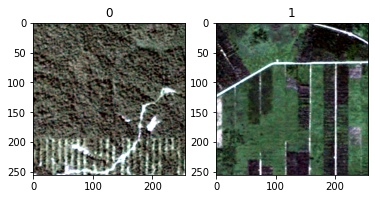

In [ ]:
#Visualize the normalized data

def visualize_data(data,label1,data2,label2 ):
    f, axarr = plt.subplots(1,2)
    
    #histogram equalization
    data = data[:, :, 0:3]
    _ = data[:, :, 0].copy()
    data[:, :, 0] = data[:, :, 2]
    data[:, :, 2] = _
    data = data.astype(float)
    for i in range(data.shape[2]):
        p2, p98 = np.percentile(data[:, :, i], (2, 98))
        data[:, :, i] = exposure.rescale_intensity(data[:, :, i],
                                                      in_range=(p2, p98))
    #histogram equalization complete for data1
    axarr[0].imshow(data)
    axarr[0].set_title(f"{label1}")
    data2 = data2[:, :, 0:3]
    _ = data2[:, :, 0].copy()
    data2[:, :, 0] = data2[:, :, 2]
    data2[:, :, 2] = _
    data2 = data2.astype(float)
    for i in range(data2.shape[2]):
        p2, p98 = np.percentile(data2[:, :, i], (2, 98))
        data2[:, :, i] = exposure.rescale_intensity(data2[:, :, i],
                                                      in_range=(p2, p98))
    a=axarr[1]
    im = axarr[1].imshow(data2)
    a.set_title(f"{label2}")

visualize_data(X[1,:,:,:].swapaxes(0,2),Y[1],X[14,:,:,:].swapaxes(0,2),Y[14] ) #Visualize Images Side by Side

Above a specific function for visualization of available dataset was created so as to visualize them in more efficient manner. Concept of histogram equalization from image analysis is also included so that maintain contrast of the image.

## Converting numpy to tensor data

In [ ]:
#setting seed for reproducibility
import random
SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
#convert dataset to tensor

tensor_x = torch.Tensor(X) 
tensor_y_float = torch.Tensor(Y)
tensor_y=tensor_y_float.type(torch.LongTensor)
tensor_dataset = TensorDataset(tensor_x,tensor_y) 

The initial idea was to treat the entire dataset for training purposes but later, being practical, I decided to divide the dataset to prepare, and validation set where later in data loader additional test_set can also be added in case needed.  

In [ ]:
#splitting data to train and validation set
VALID_RATIO = 0.9  #10% of the entire dataset is used as validation set whereas rest 90% is train set 

n_train_examples = int(len(tensor_dataset) * VALID_RATIO)
n_valid_examples = len(tensor_dataset) - n_train_examples

train_data, valid_data = random_split(tensor_dataset, 
                                           [n_train_examples, n_valid_examples])

and then overwrite the validation transforms, making sure to do a deepcopy to stop this also changing the training data transforms.

In [ ]:
valid_data = copy.deepcopy(valid_data)

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

Number of training examples: 6909
Number of validation examples: 768


In this task, I thought of setting the batch size to 12, which is very uncommon compared to most of the tasks performed and discussed over the internet. It was also assumed that minimum size might make it difficult to find local minima, but since my data was not very large, I thought of sticking to the 12 batch size and observing the model's performance. 

In [ ]:
BATCH_SIZE = 12

train_iterator = DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

#if needed
# test_iterator = data.DataLoader(test_data,batch_size = BATCH_SIZE) ###but here test_data should also be defined initially

At the end of this section, we are ready with a dataset to train the model and a validation set. Since the dataset is imbalanced, I decided to keep a low validation data ratio. I cannot present any concrete answer, but I thought if I train my model with a large dataset. In the test phase, my dataset will encounter a similar set, thus increasing the accuracy of my model. 

## Defining the network

Based on several blogs on the internet, I realised that ResNet is one of the widely used models for classification tasks. Specifically, ResNet, as in most deep networks, is hard to train because of the vanishing gradient problem. But in the residual network, they have a solution to vanishing gradient as it introduced the concept of skip connection that helps resolve the issue. Also, it was very popular and said to be one of the efficient methods. Therefore, I decided to use and explore residual network (ResNet) models for this task.


For completing this task I took guidance from this github page: https://github.com/bentrevett/pytorch-image-classification

Conv layers are stacked one after another as in a simple traditional network, but here we will also have added original input to the output of a convolution block. This is called skip connection. Because some layers are getting skipped by setting all their weights to zero, the value will not reach tiny matters. 

I learned that the logic behind the Residual network is to make y=x, and it could be possible if we make f(x)=0. In a typical network, we learn from y, but in the residual network, we know from f(x), and our target is to make f(x) = 0, then only we can make input=output. 

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

Our ResNet class defines the initial 7x7 convolutional layer, batch normalisation, a ReLU activation function, and a downsampling max-pooling layer are defined by our ResNet class. The four layers are then constructed using the provided configuration, config, which specifies the block to be used, the number of blocks in the layer, and the number of channels. The number of channels in a layer for the BasicBlock is the number of filters for both convolutional layers within the block.

In [ ]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

The BasicBlock is made of two 3x3 convolutional layers. The first, conv1, has stride which varies depending on the layer (one in the first layer and two in the other layers), whilst the second, conv2, always has a stride of one. Each of the layers has a padding of one - this means before the filters are applied to the input image we add a single pixel, that is zero in every channel, around the entire image. Each convolutional layer is followed by a ReLU activation function and batch normalization.

The BasicBlock has an expansion of one as the number of filters used by each of the convolutional layers within a block is the same.

namedtuple will store: the block class, the number of blocks in each layer, and the number of channels in each layer.

In [ ]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In the following sections, I aim to compare the performance of the 2 ResNet models (ResNet18 and ResNet34) where ResNet18 has two blocks containing two 3x3 convolutional layers with 64 filters Resnet34 has three.

## First Model : Resnet 18 

The Resnet18 Model is a simple yet powerful model for classification tasks. Let us try with this model first and increase the depth of the network gradually. 

In [ ]:
resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

In [ ]:
model = ResNet(resnet18_config, 2)

We can also see the number of parameters in our model.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,177,538 trainable parameters


In [ ]:
summary(model, input_size=(3,256, 256),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

### Training the model

We have defined above as learning rate finder to define a suitable learning rate for our model.

How does the learning rate finder work? We give the finder our model, optimizer and criterion we want to use. However we give it an optimizer with a much lower learning rate than we are expecting to use. We then train the model on the batches of data from the training set - calculating the loss and updating the parameters. After each batch we increase the learning rate exponentially from the initial, extremely low learning rate to a learning rate we know will be too high. This repeats until our loss diverges (over 5x the best loss achieved) or we reach our defined maximum learning rate.

At each batch we are recording the learning rate and the loss achieved on that batch. By plotting them against each other we can find a suitable learning rate

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#defining a class that will help in finding learning rate
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()
class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [ ]:
END_LR = 100
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


Next, we define a function to plot the results of the range test.

In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

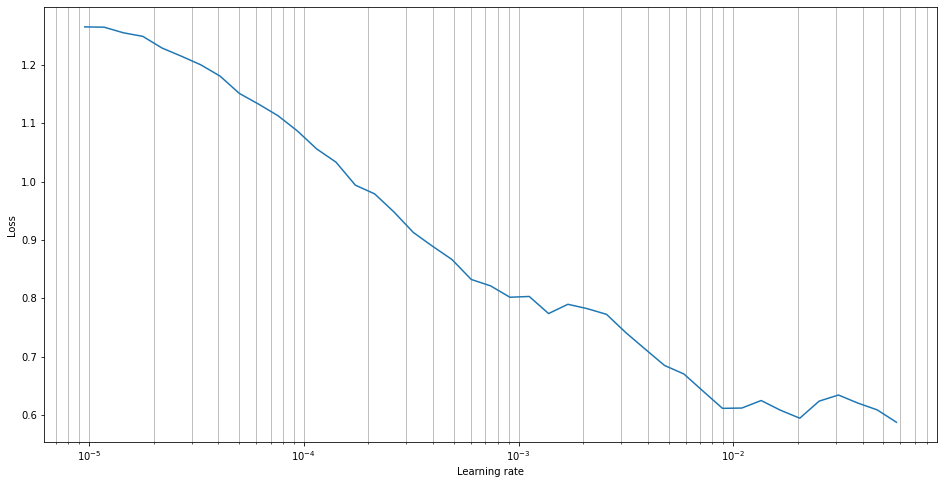

In [ ]:
plot_lr_finder(lrs, losses, skip_start = 20, skip_end = 20)

As our learning rate was scaled up exponentially, we plotted it on a logarithmic scale. As we can see, the loss begins flat and then decreases rapidly before reaching a minimum and starting to increase.

We use the learning rate found by the learning rate finder as the maximum learning rate - used in the final layer - whilst the remaining layers have a lower learning rate, gradually decreasing towards the input.

In [ ]:
FOUND_LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

I have also used a learning rate scheduler, a PyTorch wrapper, around an optimizer that allows us to dynamically alter its learning rate during training.

To set-up the learning rate scheduler we need the total number of steps that will occur during training. We simply get this by multiplying the number of epochs with the number of batches in the training iterator, i.e. number of parameter updates. We get the maximum learning rate for each parameter group and pass this to max_lr.

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

As per the requirement of the assignment performance of the model should be evaluated with F1 score along with the overall accuracy and loss of the model. Thus a function for computing F1 score was also introduced in the workflow below.

In [ ]:
label_values=['No Plam','Palm']
epsilon=1e-8

def calculate_acc_f1Score(y_pred, y):
    with torch.no_grad():
        y_pred = np.argmax(y_pred.data.cpu().numpy(), axis=1)
        y = y.data.cpu().numpy()
        accuracy=accuracy_score(y,y_pred)
        f1=f1_score(y,y_pred,pos_label=1,zero_division=1)
        #print(accuracy,)
    return accuracy, f1

The scheduler is updated by calling scheduler.step(). This should always be called after optimizer.step() or else the first learning rate of the scheduler will be skipped.

Not all schedulers need to be called after each training batch, some are only called after each epoch. In that case, the scheduler does not need to be passed to the train function and can be called in the main training loop.

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_f1 = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc, f1 = calculate_acc_f1Score(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_f1 += f1.item()
        
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
    epoch_f1 /= len(iterator)
        
    return epoch_loss, epoch_acc, epoch_f1

In [ ]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    
    #model.eval()    ## here i skipped the part of calling model.eval as it was initializing my loss as nan
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)
            #print(loss)

            acc, f1 = calculate_acc_f1Score(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_f1 += f1.item()
    #print(len(iterator))    
    epoch_loss /= len(iterator)
    epoch_acc /= len(iterator)
    epoch_f1 /= len(iterator)
        
    return epoch_loss, epoch_acc, epoch_f1

A simple function to keep record of number of epoch other than using tqdm was used in this task.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_f1 = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_f1 < best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model.state_dict(), 'Resnet18_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% | ' \
          f'Train F1: {train_f1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}% | ' \
          f'Valid F1: {valid_f1*100:6.2f}%')

Epoch: 01 | Epoch Time: 1m 34s
	Train Loss: 0.313 | Train Acc :  87.62% | Train F1:  38.89%
	Valid Loss: 0.273 | Valid Acc :  91.41% | Valid F1:  52.39%
Epoch: 02 | Epoch Time: 1m 33s
	Train Loss: 0.268 | Train Acc :  89.47% | Train F1:  43.59%
	Valid Loss: 0.289 | Valid Acc :  91.67% | Valid F1:  58.64%
Epoch: 03 | Epoch Time: 1m 33s
	Train Loss: 0.263 | Train Acc :  90.34% | Train F1:  48.17%
	Valid Loss: 0.262 | Valid Acc :  92.06% | Valid F1:  58.59%
Epoch: 04 | Epoch Time: 1m 33s
	Train Loss: 0.260 | Train Acc :  90.00% | Train F1:  47.55%
	Valid Loss: 0.261 | Valid Acc :  90.36% | Valid F1:  54.66%
Epoch: 05 | Epoch Time: 1m 34s
	Train Loss: 0.245 | Train Acc :  90.63% | Train F1:  51.22%
	Valid Loss: 0.356 | Valid Acc :  90.76% | Valid F1:  51.41%
Epoch: 06 | Epoch Time: 1m 33s
	Train Loss: 0.234 | Train Acc :  91.12% | Train F1:  54.33%
	Valid Loss: 0.277 | Valid Acc :  91.41% | Valid F1:  56.00%
Epoch: 07 | Epoch Time: 1m 32s
	Train Loss: 0.223 | Train Acc :  91.28% | Train F1

As seen above, fair value for overall accuracy was achieved for both training and validation set but slightly different for the F1 score. Yet, a model with the highest validation f1 score was saved as Resnet_model.pt.

F1 score was selected as an evaluation method in this case, primarily because we were asked to use it. Other than that, I think the information on this will give a better idea when dealing with a dataset that is not balanced.

## Lets Try Second Model ResNET34

With similar environment setting another architecture with slightly different structure was then evaluated for comparison i.e ResNet34.
This model has the same architecture as above but consists of more layers and can extract features from much more depth. The Architecture diagram of the model looks like following:
![image.png](attachment:a02ced9c-8d90-481f-8f36-34bd8e44a5df.png)

In [ ]:
resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

In [ ]:
model = ResNet(resnet34_config, 2)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 21,285,698 trainable parameters


In [ ]:
summary(model, input_size=(3,256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

### Training Resnet34 Model

In [ ]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Stopping early, the loss has diverged


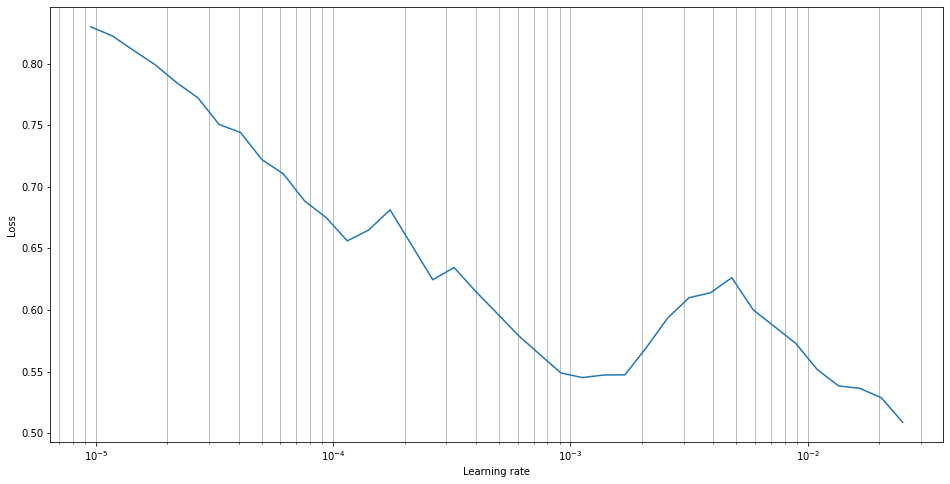

In [ ]:
END_LR = 100
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)
plot_lr_finder(lrs, losses, skip_start = 20, skip_end = 20)

In [ ]:
FOUND_LR = 1e-4

params = [
          {'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.bn1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.layer1.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.layer2.parameters(), 'lr': FOUND_LR / 6},
          {'params': model.layer3.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.layer4.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = FOUND_LR)

In [ ]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [ ]:
best_valid_f1 = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_f1 < best_valid_f1:
        best_valid_f1 = valid_f1
        torch.save(model.state_dict(), 'Resnet34_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc : {train_acc*100:6.2f}% | ' \
          f'Train F1: {train_f1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc : {valid_acc*100:6.2f}% | ' \
          f'Valid F1: {valid_f1*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 31s
	Train Loss: 0.363 | Train Acc :  85.92% | Train F1:  25.33%
	Valid Loss: 0.303 | Valid Acc :  87.76% | Valid F1:  30.42%
Epoch: 02 | Epoch Time: 2m 29s
	Train Loss: 0.286 | Train Acc :  88.87% | Train F1:  39.39%
	Valid Loss: 0.279 | Valid Acc :  89.45% | Valid F1:  47.81%
Epoch: 03 | Epoch Time: 2m 29s
	Train Loss: 0.270 | Train Acc :  89.54% | Train F1:  43.80%
	Valid Loss: 0.276 | Valid Acc :  89.19% | Valid F1:  43.18%
Epoch: 04 | Epoch Time: 2m 29s
	Train Loss: 0.256 | Train Acc :  90.06% | Train F1:  46.80%
	Valid Loss: 0.265 | Valid Acc :  89.71% | Valid F1:  48.34%
Epoch: 05 | Epoch Time: 2m 30s
	Train Loss: 0.242 | Train Acc :  90.39% | Train F1:  50.32%
	Valid Loss: 0.289 | Valid Acc :  88.41% | Valid F1:  51.78%
Epoch: 06 | Epoch Time: 2m 29s
	Train Loss: 0.210 | Train Acc :  91.60% | Train F1:  58.08%
	Valid Loss: 0.277 | Valid Acc :  89.97% | Valid F1:  53.07%
Epoch: 07 | Epoch Time: 2m 29s
	Train Loss: 0.179 | Train Acc :  93.34% | Train F1

From the above observation, ResNet18 gave better results in my case as compared to ResNet34. In the case of ResNet34 better result was achieved at epoch 14 so, I assume that increasing the number of epochs might not help to get a better solution but maybe I was not accurate enough to assign the learning rate in this case. Compared to the previous model, I tried several learning rates due to not having better performance. Thus, I assume that one of my flaws is selecting the learning rate. 

I believe that the I wasn't able to achieve a better result for validation dataset because of not well distributed dataset, the dataset seems to be quite unbalance and on top of that I selected only 10% as validation dataset whereas rest of them were my training set. Ofcourse this might have result to slight overfitting of data but when I increase my validation set ratio, I encounter issue in finding the best learning rate. So with this tradeoff I decided to keep less ratio for validation dataset where as more for training.

------------------------Thank you----------------